In [111]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import itertools
import warnings

In [2]:
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#https://www.kaggle.com/poiupoiu/how-to-use-sarimax
#https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

## Reading and preprocessing the data


### NASA GISTEMP Global Means

In [112]:
glb = read_csv('weather_data/GLB.Ts.csv', skiprows=1)
glb.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.76,-0.35,-0.42,-0.60,-0.30,-0.42,-0.41,0.13,-0.44,-0.60,-0.45,-0.47,-0.43,***,***,-0.44,-0.24,-0.50
1,1881,-0.74,-0.56,-0.31,-0.21,0.02,-1.05,-0.47,-0.19,-0.29,-0.42,-0.50,-0.09,-0.40,-.43,-.59,-0.16,-0.57,-0.40
2,1882,0.18,-0.05,-0.03,-0.54,-0.33,-0.97,-0.66,-0.06,-0.02,-0.25,-0.34,-0.62,-0.31,-.26,.01,-0.30,-0.56,-0.20
3,1883,-0.62,-0.89,-0.40,-0.26,-0.30,0.50,0.04,-0.10,-0.40,-0.51,-0.63,-0.33,-0.32,-.35,-.71,-0.32,0.15,-0.51
4,1884,-0.56,-0.30,-0.36,-0.90,-1.16,-0.79,-0.81,0.19,-0.33,-0.73,-0.78,-0.97,-0.63,-.57,-.40,-0.81,-0.47,-0.61


In [113]:
#https://data.giss.nasa.gov/gistemp/
def preprocess_temp_anomaly(anomaly):
    
    col_names =  ['DateTime', 'anomaly']
    glb_formatted = pd.DataFrame(columns = col_names)
    
    at = 0
    for index, row in glb.iterrows():
        i = 0
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        for r in row[1:13]:
            date = pd.to_datetime(str(row['Year']) + '-' + months[i])
            value = r
            glb_formatted.loc[at] = [date, value]
            at = at + 1
            i = i + 1
        i= 1
    
    glb_formatted = glb_formatted.set_index(['DateTime'])
    
    return glb_formatted


glb_formatted = preprocess_temp_anomaly(glb)
glb_formatted.head()

,anomaly
DateTime,
1880-01-01,-0.76
1880-02-01,-0.35
1880-03-01,-0.42
1880-04-01,-0.60
1880-05-01,-0.30


### Monthly mean carbon dioxide at Mauna Loa Observatory, Hawaii

In [114]:
columns= ['Year', 'Month', 'Excel', 'Date', 'CO2', 'sesonalCO2', 'FIT','sesonalFIT', 'CO2filled', 'seasonalCO2filled']

maunaloa = read_csv('weather_data/maunaloa.csv', skiprows=57, header=None, names=columns)

maunaloa['DateTime']  = pd.to_datetime(maunaloa.Year.map(str) + '-' + maunaloa.Month.map(str))
maunaloa = maunaloa.set_index(['DateTime'])

maunaloa.head()

,Year,Month,Excel,Date,CO2,sesonalCO2,FIT,sesonalFIT,CO2filled,seasonalCO2filled
DateTime,,,,,,,,,,
1958-01-01,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-02-01,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-03-01,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
1958-04-01,1958,4,21290,1958.2877,317.45,315.15,317.30,314.98,317.45,315.15
1958-05-01,1958,5,21320,1958.3699,317.51,314.72,317.85,315.06,317.51,314.72


In [115]:
maunaloaFilled = maunaloa[['CO2filled', 'seasonalCO2filled']].copy()
maunaloaFilled.replace(to_replace=[-99.99], value=np.nan, inplace=True)

### The Oceanic Niño Index (ONI) 

In [116]:
#https://data.humdata.org/dataset/monthly-oceanic-nino-index-oni
#https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt

In [117]:
enso = read_csv('weather_data/ONIindex.csv',delim_whitespace=True)

In [118]:
enso['DateTime'] = pd.to_datetime(enso.YR.map(str) + '-' + enso.MON.map(str))
enso = enso.set_index(['DateTime']) 

In [119]:
enso.head()

,YR,MON,TOTAL,ClimAdjust,ANOM
DateTime,,,,,
1950-01-01,1950,1,24.56,26.18,-1.62
1950-02-01,1950,2,25.07,26.39,-1.32
1950-03-01,1950,3,25.88,26.95,-1.07
1950-04-01,1950,4,26.29,27.39,-1.11
1950-05-01,1950,5,26.19,27.56,-1.37


### Sunspot Number

In [120]:
#http://www.sidc.be/silso/monthlyssnplot
#http://www.sidc.be/silso/newdataset
columns= ['Year', 'Month', 'decimalYear', 'SNvalue' , 'SNerror', 'NBobservations', 'unspesified']
sunspots = read_csv('weather_data/SN_m_tot_V2.0.csv', sep=';', header=None, names=columns)

In [121]:
sunspots['DateTime'] = pd.to_datetime(sunspots.Year.map(str) + '-' + sunspots.Month.map(str))

In [122]:
sunspots = sunspots.set_index(['DateTime'])  

In [123]:
sunspots.head()

,Year,Month,decimalYear,SNvalue,SNerror,NBobservations,unspesified
DateTime,,,,,,,
1749-01-01,1749,1,1749.042,96.7,-1.0,-1,1
1749-02-01,1749,2,1749.123,104.3,-1.0,-1,1
1749-03-01,1749,3,1749.204,116.7,-1.0,-1,1
1749-04-01,1749,4,1749.288,92.8,-1.0,-1,1
1749-05-01,1749,5,1749.371,141.7,-1.0,-1,1


### Range there is data of all the variables

In [124]:
#Choosing a range there is data of
anomalyrange = glb_formatted['1960-01-01' : '2018-12-01']
co2range = maunaloaFilled[['CO2filled']]['1960-01-01' : '2018-12-01']  #.CO2filled['1960-01-01' : '2018-12-01']
ensorange = enso[['ANOM']]['1960-01-01' : '2018-12-01']
spotsrange = sunspots[['SNvalue']]['1960-01-01' : '2018-12-01']

In [125]:
anomalyrange.to_csv('gridsearch_data/anomalyrange.csv')
co2range.to_csv('gridsearch_data/co2range.csv')
ensorange.to_csv('gridsearch_data/ensorange.csv')
spotsrange.to_csv('gridsearch_data/spotsrange.csv')

In [126]:
exogenous = pd.concat([co2range,ensorange,spotsrange], axis=1)

In [127]:
exogenous.tail()

,CO2filled,ANOM,SNvalue
DateTime,,,
2018-08-01,407.10,0.04,8.7
2018-09-01,405.59,0.39,3.3
2018-10-01,405.99,0.86,4.9
2018-11-01,408.12,0.86,5.9
2018-12-01,409.23,0.84,3.1


## Plotting the data

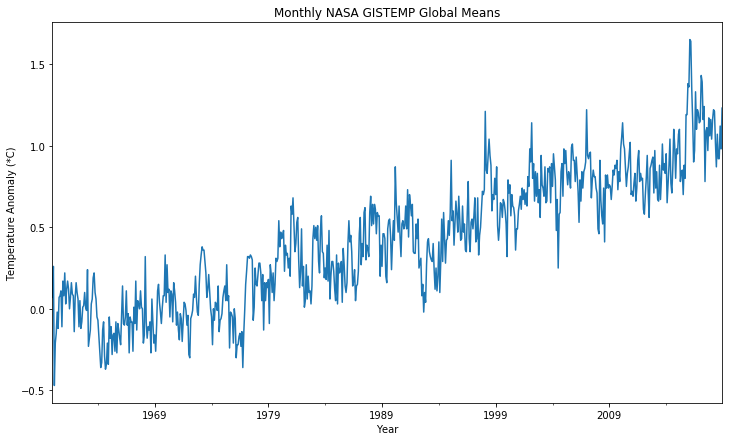

In [128]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
anomalyrange.anomaly.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (*C)')
plt.title('Monthly NASA GISTEMP Global Means')
plt.show()


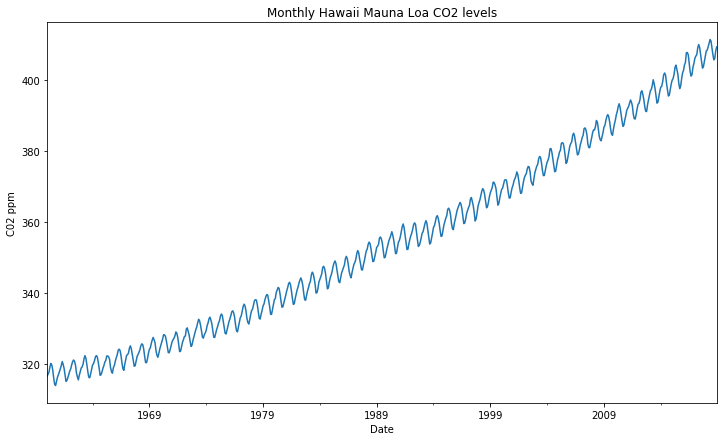

In [129]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
co2range.CO2filled.plot(ax=ax)

plt.xlabel('Date')
plt.ylabel('C02 ppm')
plt.title('Monthly Hawaii Mauna Loa CO2 levels')
plt.show()

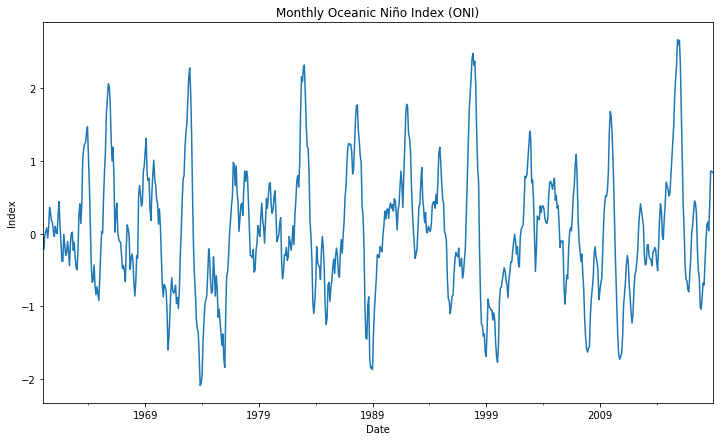

In [130]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
ensorange.ANOM.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Monthly Oceanic Niño Index (ONI)')
plt.show()

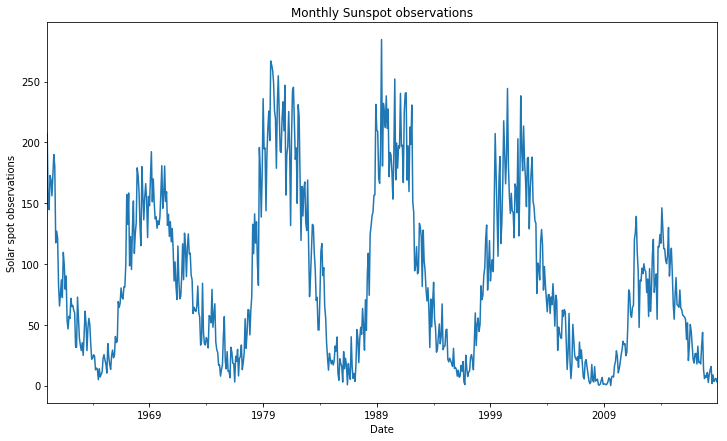

In [131]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
spotsrange.SNvalue.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Solar spot observations')
plt.title('Monthly Sunspot observations')
plt.show()

## Seasonal Decompositions

### Temperature anomaly

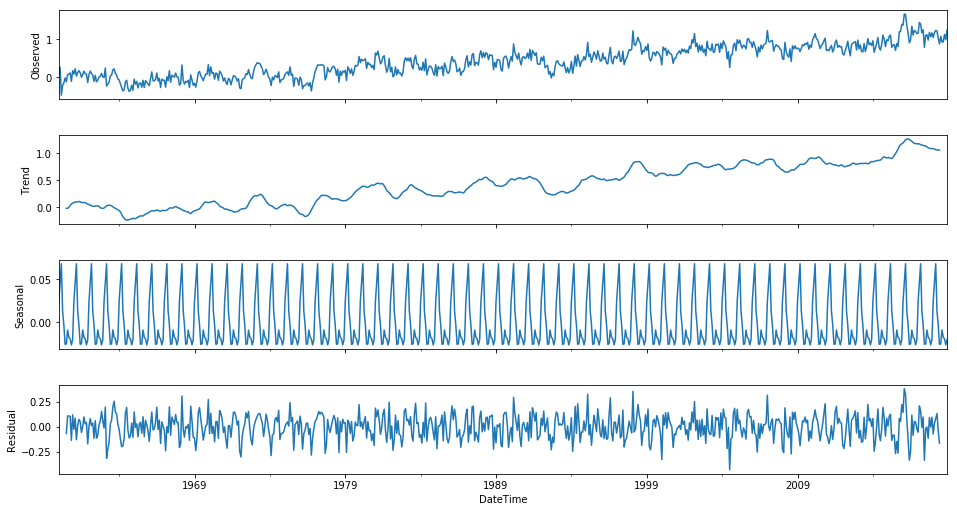

In [22]:
res = sm.tsa.seasonal_decompose(anomalyrange.anomaly,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Hawaii CO2 ppm 

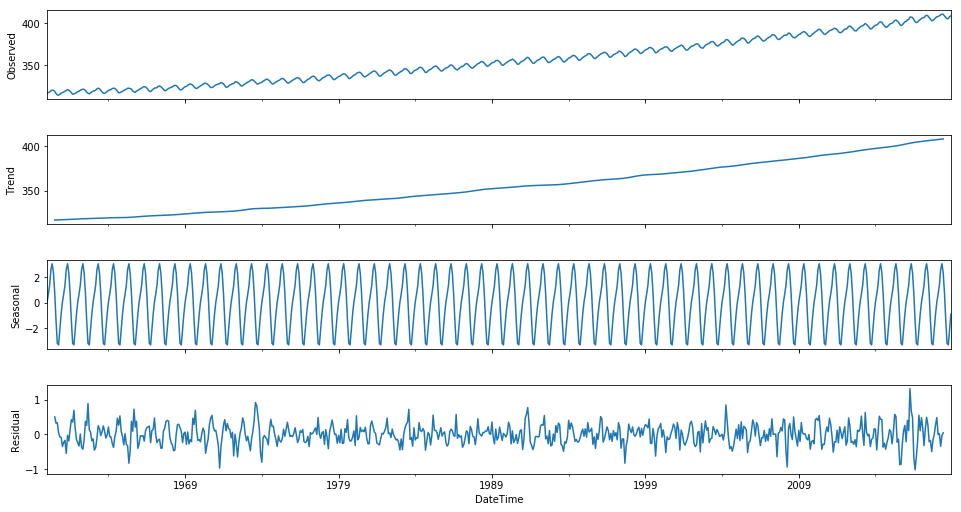

In [23]:
res = sm.tsa.seasonal_decompose(co2range.CO2filled,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### The Oceanic Niño Index (ONI)

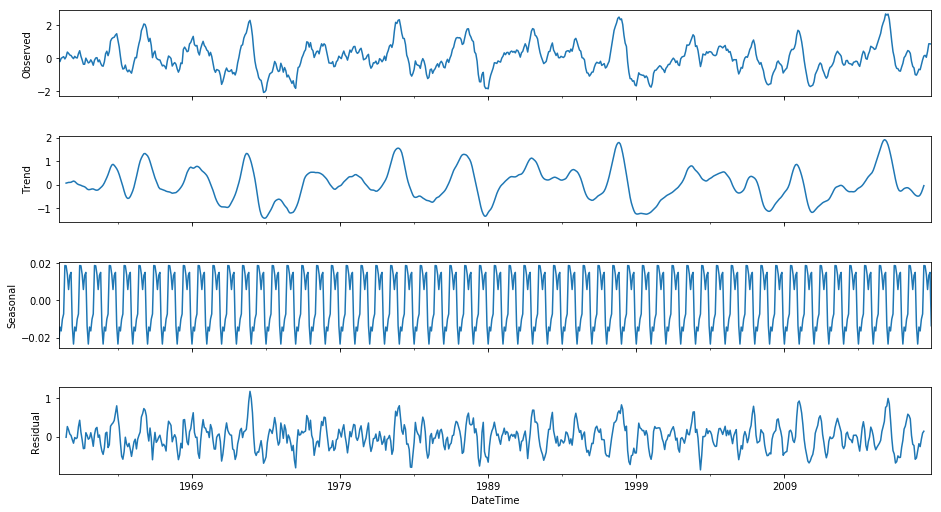

In [24]:
res = sm.tsa.seasonal_decompose(ensorange.ANOM,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Sunspot observations

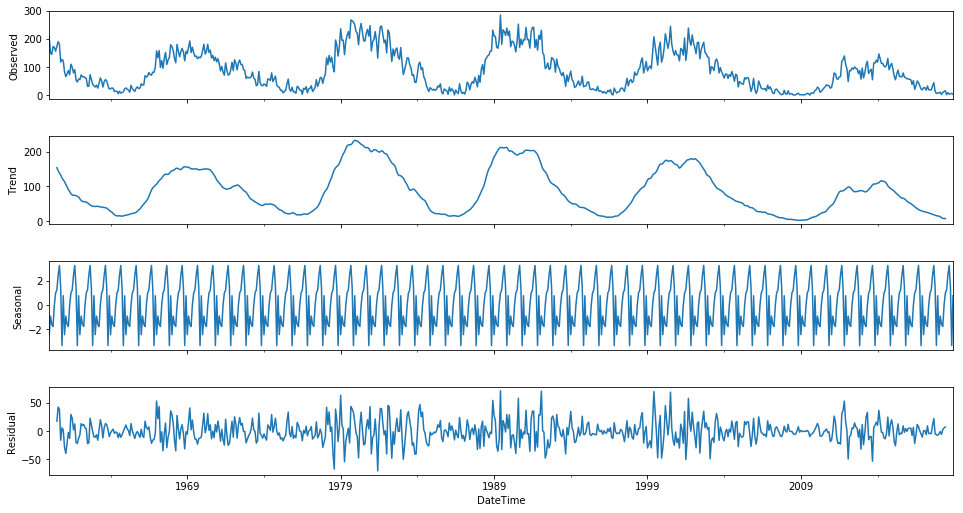

In [25]:
res = sm.tsa.seasonal_decompose(spotsrange.SNvalue,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## Model Selection

In [26]:
#ARIMA model:(p,d,q)
#SARIMA model:(p,d,q)(P,D,Q,m)
#ARIMAX model:(p,d,q) + exog
#SARIMAX model:(p,d,q)(P,D,Q,m) +exog

#ARIMA(p,d,q)
#p is the number of autoregressive terms,
#d is the number of nonseasonal differences needed for stationarity, and
#q is the number of lagged forecast errors in the prediction equation.

#P: Seasonal autoregressive order.
#D: Seasonal difference order.
#Q: Seasonal moving average order.
#m: The number of time steps for a single seasonal period.

### Checking Stationarity (Trend)

#### Temperature anomaly

Temperature anomaly lacks identifiable seasonal trend, but has a constant trend

In [27]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='ct')
print('p-value:{}'.format(res[1]))
# data does not have a unit root and is stationary

p-value:1.6042922157092146e-09


In [28]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.5914744988244862


#### Hawaii CO2 ppm 

CO2 concentration has both a seasonal and a constant trend

In [29]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.9885944880242227


In [30]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:1.0


#### The Oceanic Niño Index (ONI) and Sunspot observations

ONI and Sunspot observations have no trend

In [31]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:4.519555052443993e-08


In [32]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:2.5062854384841634e-09


In [33]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0030167208232305537


In [34]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0007375824522553518


### Correlograms

#### Temperature anomaly

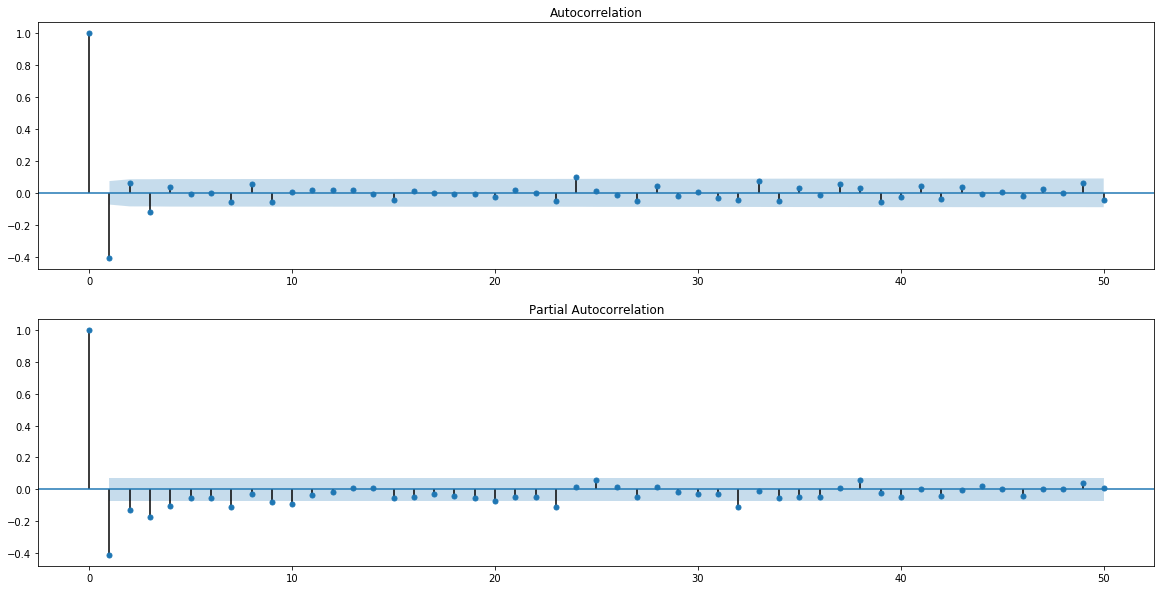

In [36]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### Hawaii CO2 ppm

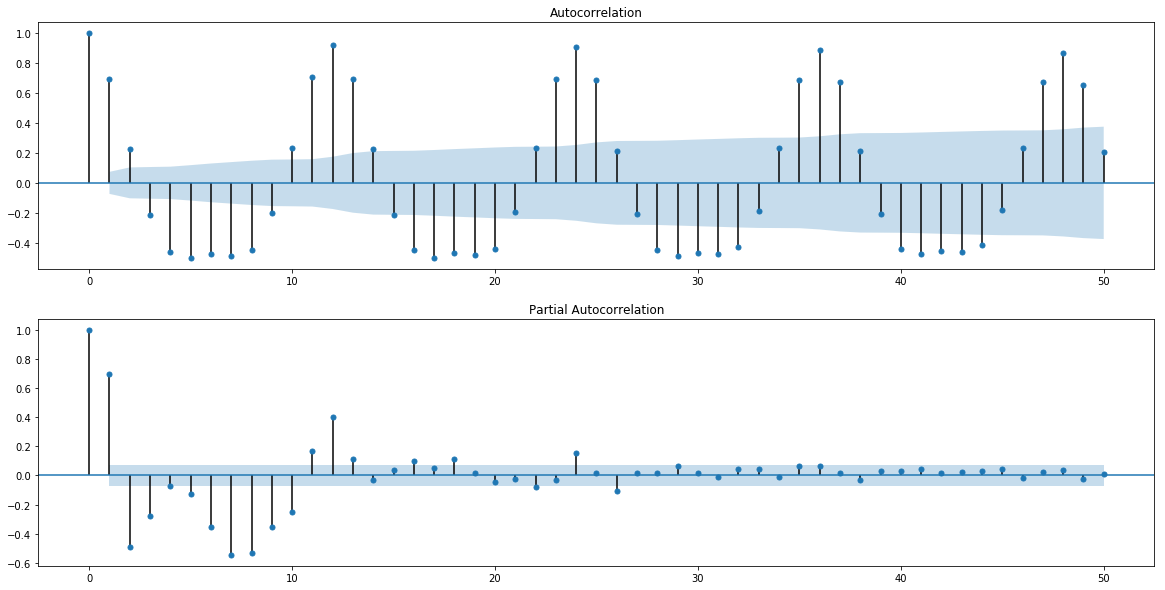

In [37]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### The Oceanic Niño Index (ONI) 

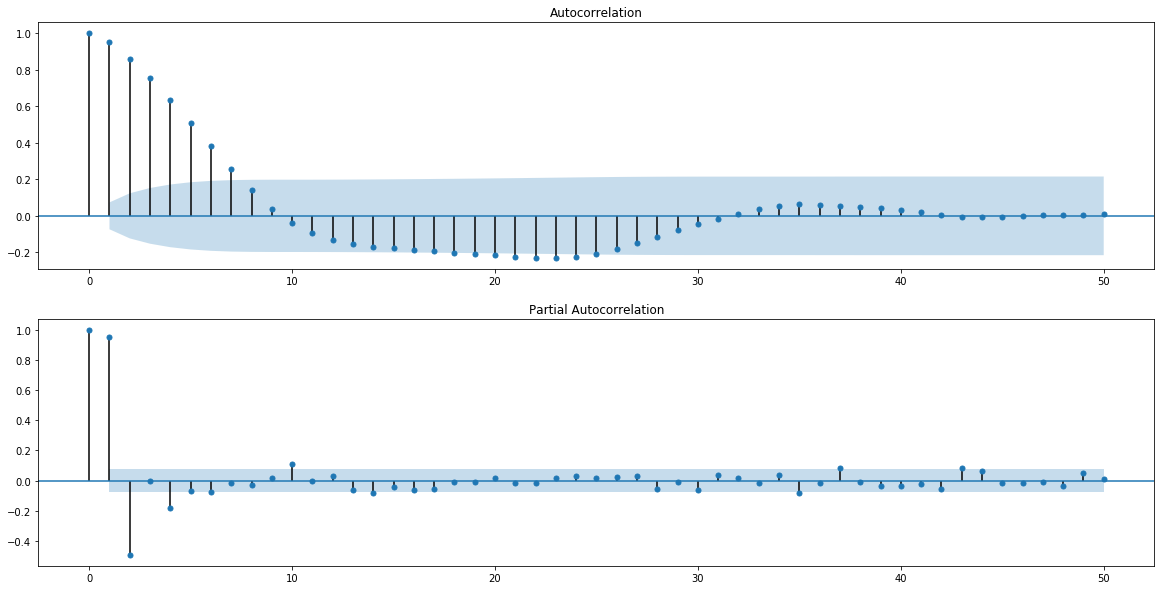

In [38]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ensorange.ANOM, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ensorange.ANOM, lags=50, ax=ax[1])
plt.show()

#### Sunspot observations

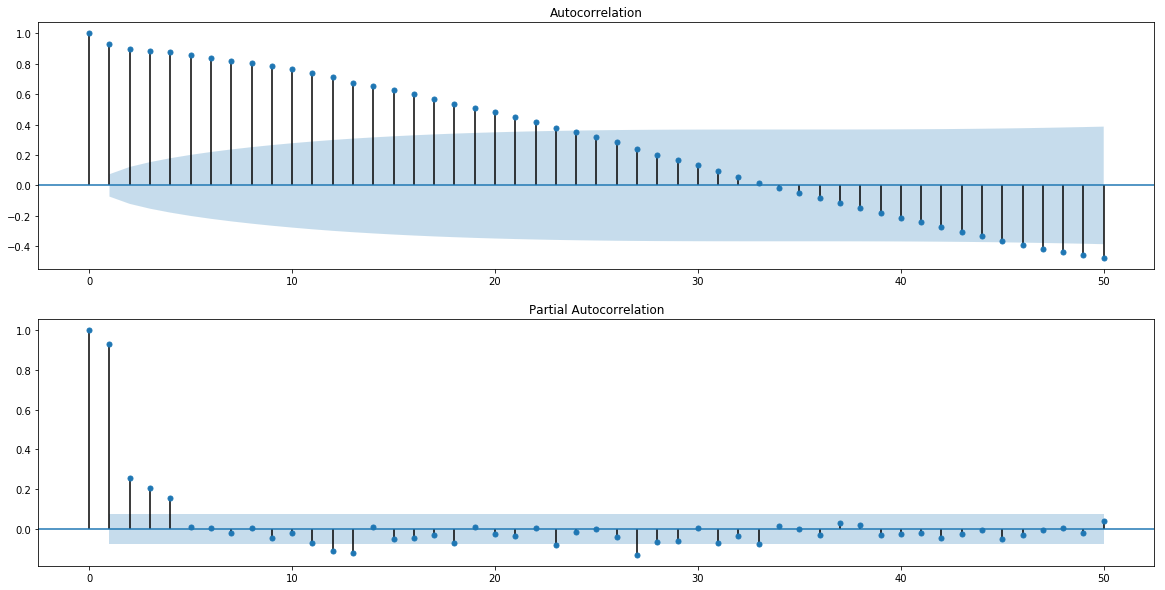

In [39]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(spotsrange.SNvalue, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(spotsrange.SNvalue, lags=50, ax=ax[1])
plt.show()

### Train/Test-split

In [132]:
tr_start,tr_end = '1960-01-01','2012-12-01'
te_start,te_end = '2013-01-01','2018-12-01'

train_anomaly, test_anomaly = anomalyrange[tr_start : tr_end], anomalyrange[te_start:te_end]
train_co2, test_co2 = co2range[tr_start : tr_end], co2range[te_start: te_end]
train_enso, test_enso = ensorange[tr_start : tr_end], ensorange[te_start: te_end]
train_spots, test_spots = spotsrange[tr_start : tr_end], spotsrange[te_start: te_end]
train_exogenous, test_exogenous = exogenous[tr_start : tr_end], exogenous[te_start: te_end]


### Gridsearch Hyperparameter selection

! Was not used as the final model did not rely on the future prediction of exogenous variables

SARIMA-gridsearch code from:
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/


format gridsearch.py filename.csv. You need to edit the sys.argv[1] parameter in to run these commands


In [ ]:
%run -i gridsearch.py anomalyrange.csv

In [55]:
#Best parameters for anomaly:
#[(2, 0, 2), (2, 0, 0, 0), 'c'] 0.16027624541442012
#[(2, 1, 2), (0, 0, 0, 0), 'c'] 0.16167729212744297
#[(1, 1, 1), (0, 0, 2, 0), 'c'] 0.16190864182572434

In [ ]:
%run -i gridsearch.py co2range.csv

In [ ]:
#Best parameters for co2:
#
#
#

In [ ]:
%run -i gridsearch.py ensorange.csv

In [ ]:
#Best parameters for enso:
#
#
#

In [ ]:
%run -i gridsearch.py spotsrange.csv

In [109]:
#Best parameters for spots:
#
#
#

### Comparing results to auto.arima parameters

#### Temperature anomaly

In [108]:
#resDiff = sm.tsa.arma_order_select_ic(train_anomaly.anomaly,max_ar=5, max_ma =5, ic=['aic', 'bic', 'hqic'], trend='c')

In [94]:
print ('AIC-order: {}' .format(resDiff.aic_min_order))
print ('BIC-order: {}' .format(resDiff.bic_min_order))
print ('HQIC-order: {}' .format(resDiff.hqic_min_order))

AIC-order: (5, 4)
BIC-order: (3, 1)
HQIC-order: (3, 1)


#### CO2 concentration

In [28]:
#p = d = q = range(0, 2)
p = range(0,3)
d = range(0,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_co2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                            )

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8269.638633659904
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:8132.639847251018
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2009.3118571811438
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1818.7373335044786
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1252.5524517897957
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1251.4398868215658
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1228.517606766495
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1593.6075760440895
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1162.4557655813785
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1110.52147381763
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:1227.7935100805971
SARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:1229.0262179547158
SARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:1230.2644586260735
SARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:1417.7413165407615
SARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:1127.1361172721838
SARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:1119.7276992988109
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8361.351892637871
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC

SARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:590.0852488478015
SARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:262.4021827756402
SARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:263.0750499292577
SARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:426.9775633102142
SARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:256.230903544336
SARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:255.09965923596582
SARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:418.9922448687638
SARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:265.1768423107403
SARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:259.5261026158467
SARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:356.99619630003457
SARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:261.5512155294709
SARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:253.44283348553495
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1637.5936537626824
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1311.5371346422276
SARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:1098.4526582255758
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:611.8606781341329
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:271.449735518283
SARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:266.36

SARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:261.25571684566853
SARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:425.1593680712265
SARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:263.87161677207706
SARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:254.5199013433471
SARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:427.87053271334855
SARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:261.7699070389199
SARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:263.64988349141413
SARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:356.4548447099402
SARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:263.5648082924297
SARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:256.5204325580681
SARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:1325.7940435482471
SARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:951.2165163316298
SARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:783.7063394608573
SARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:594.6333721153752
SARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:259.2341938186733
SARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:252.86319389620763
SARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:578.2331066325725
SARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:263.

In [ ]:
#BEST SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:256.3637383017923
#SARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:252.35821520023958
#SARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:252.86319389620763

In [67]:
sarima = sm.tsa.statespace.SARIMAX(train_co2,order=(1,1,1),seasonal_order=(1,1,2,12),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
#sarima.summary()

SARIMA model MSE:2.9250383680140954


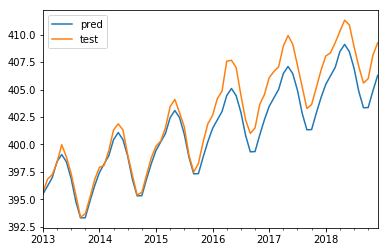

In [68]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_co2,pred)))

pd.DataFrame({'test':test_co2.values.flatten(),'pred':pred}).plot();plt.show()

#### The Oceanic Niño Index (ONI)

In [84]:
resDiff = sm.tsa.arma_order_select_ic(train_enso.ANOM,max_ar=5, max_ma =5,  ic=['aic', 'bic', 'hqic'], trend='c')

In [85]:
print ('AIC-order: {}' .format(resDiff.aic_min_order))
print ('BIC-order: {}' .format(resDiff.bic_min_order))
print ('HQIC-order: {}' .format(resDiff.hqic_min_order))

AIC-order: (4, 4)
BIC-order: (2, 2)
HQIC-order: (3, 3)


In [86]:
sarima = sm.tsa.statespace.SARIMAX(train_enso,order=(4,0,4),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
#sarima.summary()

SARIMA model MSE:0.8668605273437964


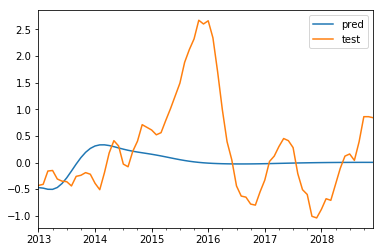

In [87]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_enso,pred)))

pd.DataFrame({'test':test_enso.values.flatten(),'pred':pred}).plot();plt.show()

#### Sunspot observations

In [88]:
resDiff = sm.tsa.arma_order_select_ic(train_spots.SNvalue,max_ar=5, max_ma =5, ic=['aic', 'bic', 'hqic'], trend='c')

In [89]:
print ('AIC-order: {}' .format(resDiff.aic_min_order))
print ('BIC-order: {}' .format(resDiff.bic_min_order))
print ('HQIC-order: {}' .format(resDiff.hqic_min_order))

AIC-order: (5, 3)
BIC-order: (2, 3)
HQIC-order: (2, 3)


In [91]:
#https://www.windows2universe.org/sun/activity/sunspot_cycle.html&edu=mid has an eleven year cycle
sarima = sm.tsa.statespace.SARIMAX(train_spots,order=(5,0,3),seasonal_order=(0,1,0,11*12),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
#sarima.summary()

SARIMA model MSE:1676.0494096274554


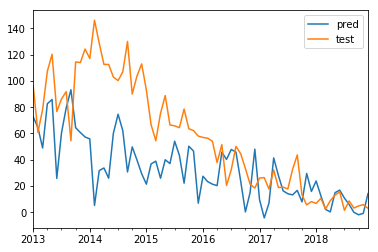

In [63]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_spots,pred)))

pd.DataFrame({'test':test_spots.values.flatten(),'pred':pred}).plot();plt.show()

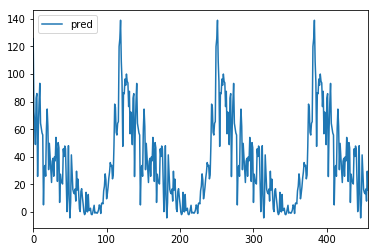

In [64]:
pred = sarima.predict(tr_end,'2050-12-01')
pd.DataFrame({'pred':pred.values}).plot();plt.show()

### Train on exogenous variables to get final SARIMAX-model parameters

In [105]:
#p = d = q = range(0, 2)
p = range(0,3)
d = range(0,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [107]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_anomaly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            exog=train_exogenous
                                            )

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:268.3668550771079
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:189.25778003545557
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-419.2603293174624
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-403.70150657918464
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-123.87929046830206
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-362.0400589150881
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-310.70875556560543
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-246.59795534660736
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-386.7188802130672
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-401.8391599539588
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-254.29146086962396
SARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-327.30543547451293
SARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:-384.4847005749366
SARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:-302.129493348883
SARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:-370.95627481282804
SARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:-399.1235818766644
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:22.918068350112804
SARIMA(0, 0, 1)x(0, 0, 1, 

SARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:-646.3041440473866
SARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:-632.2130920379844
SARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:-639.6288629455141
SARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:-653.6345936868736
SARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:-650.7556336159035
SARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:-477.04077027629296
SARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:-632.3623688031564
SARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:-632.4563512074253
SARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:-642.9123410177021
SARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:-655.8661931341701
SARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:-648.9805319622399
SARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:-519.9908114114016
SARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:-603.4274369577885
SARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:-632.9705514376766
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-622.0037554251356
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-624.3723455897697
SARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:-613.0329296691806
SARIMA(1, 1, 0)x(0, 1, 0, 12)1

SARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-628.6868578952808
SARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:-621.2702298109649
SARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-674.3897100356273
SARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:-672.4287249175377
SARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:-655.9929454363637
SARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:-471.8739164859113
SARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:-626.9855116970062
SARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:-618.5816755453721
SARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:-660.5395878566071
SARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:-657.8216513531255
SARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:-657.2060210472416
SARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:-514.5153589807915
SARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:-565.7780103277125
SARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:-620.6778400662386
SARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:-688.2766397735196
SARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:-680.2113252392235
SARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:-665.4579465762481
SARIMA(2, 1, 2)x(0, 1, 0, 12)12

In [ ]:
#Best parameters:
#SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-681.4464470288331
#SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-685.2315859480459
#SARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:-688.2766397735196

In [133]:
#https://www.windows2universe.org/sun/activity/sunspot_cycle.html&edu=mid has an eleven year cycle
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(0,1,1),seasonal_order=(0,0,0,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train_exogenous).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 345.723
Date:                Sat, 16 Feb 2019   AIC                           -681.446
Time:                        20:43:38   BIC                           -659.170
Sample:                    01-01-1960   HQIC                          -672.798
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO2filled      0.0056      0.003      1.942      0.052   -5.27e-05       0.011
ANOM           0.0215      0.015      1.484      0.138      -0.007       0.050
SNvalue     7.257e-05      0.000      0.292      0.770      -0.000       0.001
ma.L1         -0.5903      0.033    -17.778      0.000      -0.655      -0.525
sigma2         0.0196      0.001     17.663      0.000       0.017       0.022
===================================================================================
Ljung-Box (Q):                       61.99   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.01   Prob(JB):                         0.69
Heteroskedasticity (H):               1.19   Skew:                             0.06
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.06640559723921073


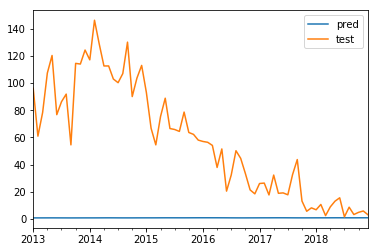

In [136]:
pred = sarimax.predict(tr_end,te_end,exog=test_exogenous)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

# Final predictions

## SARIMA model

Simple Sarima model with no exogenous variables predicts that temperature anomaly most likely stays constant

In [92]:
sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,2),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 348.486
Date:                Sat, 16 Feb 2019   AIC                           -686.971
Time:                        19:21:26   BIC                           -664.695
Sample:                    01-01-1960   HQIC                          -678.322
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0383      0.167      0.229      0.819      -0.290       0.366
ar.L2          0.3408      0.066      5.142      0.000       0.211       0.471
ma.L1         -0.5741      0.172     -3.336      0.001      -0.911      -0.237
ma.L2         -0.3235      0.150     -2.157      0.031      -0.617      -0.030
sigma2         0.0194      0.001     18.565      0.000       0.017       0.021
===================================================================================
Ljung-Box (Q):                       52.21   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.09   Prob(JB):                         0.38
Heteroskedasticity (H):               1.10   Skew:                             0.09
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.10115384567632686


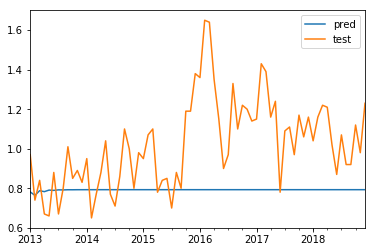

In [93]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

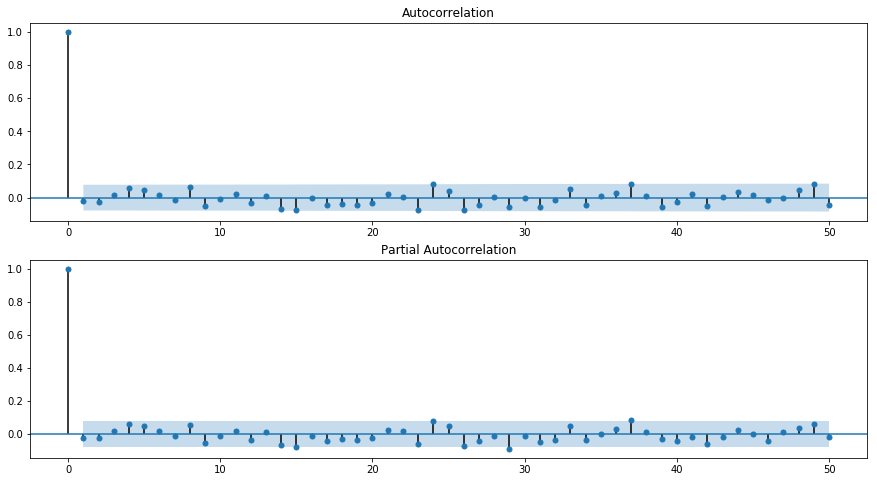

In [94]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

## SARIMAX-model with CO2 concentration

In [95]:
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,2),seasonal_order=(2,1,2,12),exog = train_co2,
                                enforce_stationarity =False, enforce_invertibility=False).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            anomaly   No. Observations:                  636
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 316.464
Date:                            Sat, 16 Feb 2019   AIC                           -612.927
Time:                                    19:22:59   BIC                           -568.375
Sample:                                01-01-1960   HQIC                          -595.630
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO2filled      0.0196      0.017      1.181      0.238      -0.013       0.052
ar.L1         -0.0200      0.231     -0.087      0.931      -0.472       0.432
ar.L2          0.3247      0.081      4.006      0.000       0.166       0.484
ma.L1         -0.5251      0.237     -2.214      0.027      -0.990      -0.060
ma.L2         -0.3538      0.204     -1.737      0.082      -0.753       0.045
ar.S.L12      -0.5860      0.262     -2.233      0.026      -1.100      -0.072
ar.S.L24       0.0003      0.000      0.808      0.419      -0.000       0.001
ma.S.L12      -0.4927      0.669     -0.737      0.461      -1.803       0.818
ma.S.L24      -0.5093      0.390     -1.306      0.191      -1.274       0.255
sigma2         0.0190      0.011      1.675      0.094      -0.003       0.041
===================================================================================
Ljung-Box (Q):                       42.95   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.35   Prob(JB):                         0.42
Heteroskedasticity (H):               1.12   Skew:                             0.08
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX model MSE:0.044568004130764734


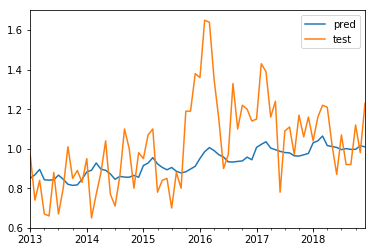

In [96]:
pred = sarimax.predict(tr_end,te_end,exog = test_co2)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

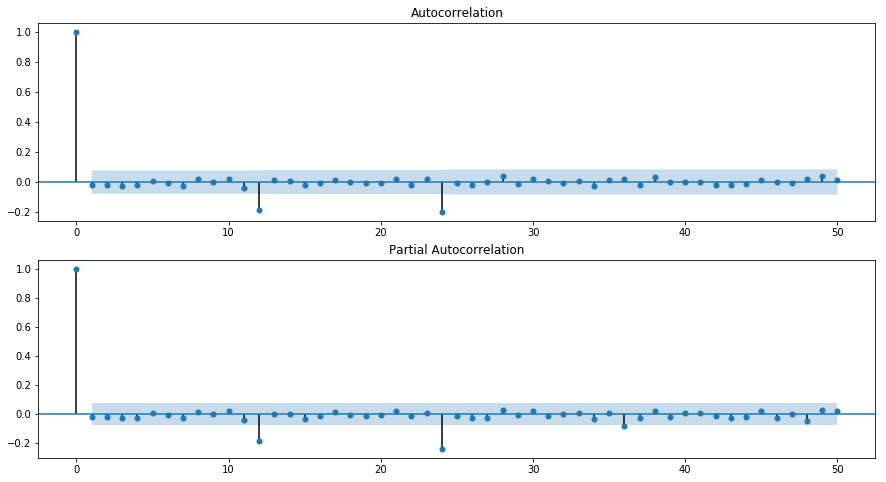

In [97]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

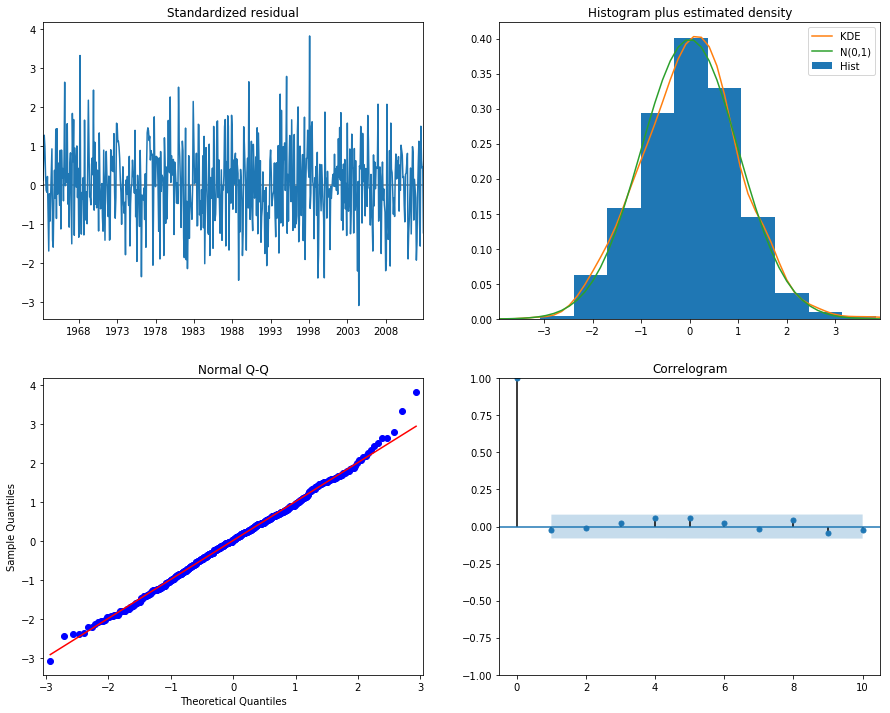

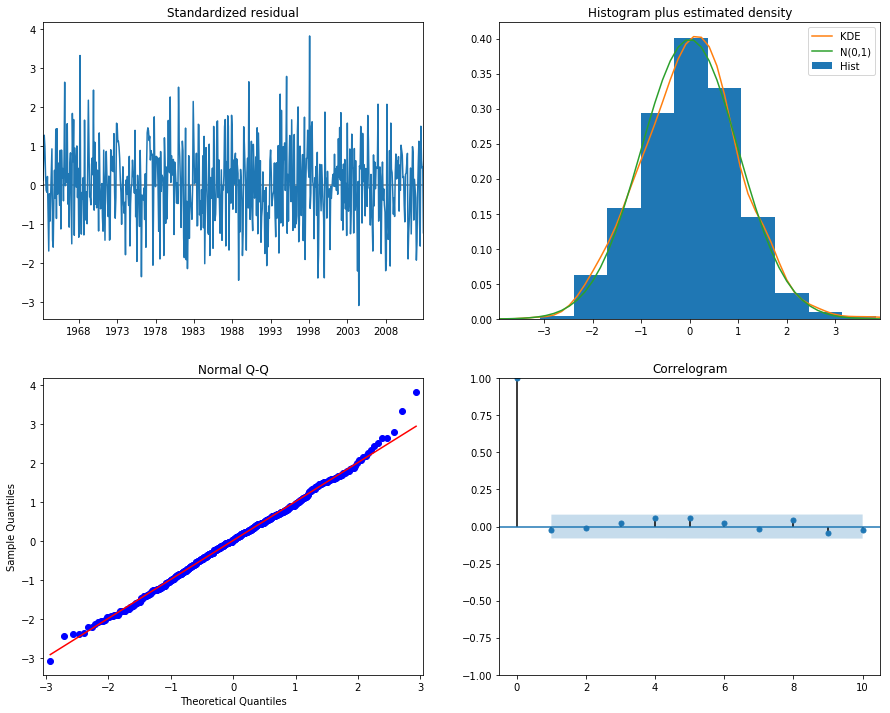

In [98]:
sarimax.plot_diagnostics(figsize=(15, 12))

## SARIMAX with all Exogenous variables

In [104]:
#sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(0,1,1),seasonal_order=(0,0,1,12),exog=train_co2,
#                                enforce_stationarity =False, enforce_invertibility=False).fit()

#ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:-572.0785421029348
#ARIMA(0, 0, 3)x(0, 1, 1, 12)12 - AIC:-578.156343087596
#ARIMA(0, 0, 3)x(1, 0, 1, 12)12 - AIC:-582.7157141925927

sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,2),seasonal_order=(0,0,0,12),exog=train_exogenous,
                                enforce_stationarity =False, enforce_invertibility=False).fit()

sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 352.138
Date:                Sat, 16 Feb 2019   AIC                           -688.277
Time:                        19:30:48   BIC                           -652.635
Sample:                    01-01-1960   HQIC                          -674.438
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO2filled      0.0060      0.003      1.862      0.063      -0.000       0.012
ANOM           0.0275      0.014      1.939      0.053      -0.000       0.055
SNvalue        0.0002      0.000      0.855      0.393      -0.000       0.001
ar.L1         -0.2843      0.154     -1.847      0.065      -0.586       0.017
ar.L2          0.2944      0.051      5.735      0.000       0.194       0.395
ma.L1         -0.2908      0.153     -1.906      0.057      -0.590       0.008
ma.L2         -0.4732      0.114     -4.165      0.000      -0.696      -0.251
sigma2         0.0192      0.001     18.277      0.000       0.017       0.021
===================================================================================
Ljung-Box (Q):                       54.58   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.06   Prob(JB):                         0.50
Heteroskedasticity (H):               1.10   Skew:                             0.05
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA model MSE:0.10115384567632686


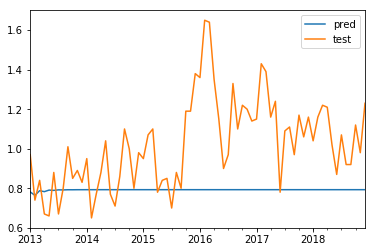

In [103]:
pred = sarima.predict(tr_end,te_end,exog=test_exogenous)
print('ARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred[1:])))
pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred[1:]}).plot();plt.show()

In [34]:
len(pred)

97